# Traffic 

!pip install --upgrade pip
!pip install palmerpenguins==0.1.4 numpy==1.23.4 pandas==1.5.1 seaborn==0.12.1 matplotlib==3.6.0 empiricaldist==0.6.7 statsmodels==0.13.5 scikit-learn==1.1.2 pyjanitor==0.23.1 session-info

## Requirements

In [1]:
!pip install --upgrade pip
!pip install palmerpenguins==0.1.4 numpy==1.23.4 pandas==1.5.1 seaborn matplotlib==3.6.0 empiricaldist==0.6.7 statsmodels==0.13.5 scikit-learn==1.1.2 pyjanitor==0.23.1 session-info missingno==0.5.2 pyreadr==0.4.7 upsetplot==0.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 123.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
  Using cached palmerpenguins-0.1.4-py3-none-any.whl (17 kB)
  Using cached pandas-1.5.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Using cached empiricaldist-0.6.7.tar.gz (11 kB)
  Preparing metadata (setup.py) ... done
  Using cached statsmodels-0.13.5-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.9 MB)
  Using cached pyjanitor-0.23.1-py3-none-any.whl (147 kB)
  Using cached session_info-1.0.0.tar.gz (24 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 54.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 25.6 MB/s eta 0:00:0

## Import Libraries

In [2]:
import empiricaldist
import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as ss
import session_info
import scipy.stats
from sklearn.neighbors import KernelDensity
import missingno
import pyreadr
import upsetplot

## Graphics Appearance

In [3]:
%matplotlib inline
sns.set_style(rc={'axes.facecolor':'#dddede'}, style = 'darkgrid')
sns.set_context(context='notebook')
plt.rcParams['figure.figsize'] = (9, 6)


continent_color = {
    'America': '#97DB4F',
    'Europe': '#0f7175ff',
    'Asia' :'#c65dc9ff',
    'Oceania':'#F9704E',
    'Africa': '#53d8fb'
}

%run pandas-missing-extension.ipynb

In [4]:
%run pandas-missing-extension.ipynb

# Data

## Load Data

In [5]:
df_traffic = pd.read_csv('data/traffic.csv')
df_traffic.columns

Index(['Country', 'Traffic Index', 'Time Index', 'Time Exp. Index',
       'Inefficiency Index', 'CO'],
      dtype='object')

## Rename Columns

In [6]:
df_traffic.columns = df_traffic.columns.str.replace(' Index', '')

df_traffic = df_traffic.rename_column('Time Exp.', 'Time_Exp')

# Explain Data

* **Traffic Index** is a composite index of time consumed in traffic due to job commute, estimation of time consumption dissatisfaction, CO2 consumption estimation in traffic and overall inefficiencies in the traffic system.

* **Time Index** is an average one way time needed to transport, in minutes.

* **Time Exp. Index** is an estimation of dissatisfaction due to long commute times. It assumes that the dissatisfaction of commute times increases exponentially with each minute after one way commute time is longer than 25 minutes.

* **Inefficiency Index** is an estimation of inefficiencies in the traffic. High inefficiencies are usually caused by the fact that people drive a car instead of using a public transport or long commute times. It can be used as a traffic component measurement in economies of scale.

* **CO2 Emission Index** is an estimation of CO2 consumption due to traffic time. Measurement unit is grams for the return trip. To calculate an average estimation of emission in grams for one way commute to work, divide this value with 2.

Actual formulas to calculate indices are subject to change and at this moment, quite complex empirical formulas are used. Those formulas as written in the Java programming language are as follows:

  protected void calculateIndex() {
    index = new TrafficIndex();
    index.time = overall.getTimeOverall();
    double tooMuchTime = 0.0;
    if (index.time > 25.0) {
      tooMuchTime = index.time - 25;
    }
    index.timeExp = index.time + Math.pow(tooMuchTime, Math.E);
    double co2 = 0.0;
    co2 += overall.time_bus * 20.0; // bus produces 20g of CO2 per minute (for each passenger)
    co2 += overall.time_driving * 133.0; // car produces 133g of CO2 per minute (assumes only driver)
    co2 += overall.time_train * 10.0; // train produces 10g of CO2 per minute (for each passenger)
    co2 += overall.time_tram * 15.0; // tram produces 15g of CO2 per minute (for each passenger)
    co2 += overall.time_other * 10.0; // other produces 10g of CO2 per minute
    co2 += overall.time_motorbike * 80.0; // motorbike produces 80g of CO2 per minute
    index.co2 = 2 * co2; 

    index.main = index.time + Math.sqrt(index.timeExp) + Math.sqrt(index.co2) + Math.sqrt(index.inefficiency);
}
To estimate number of trees to cover CO2 consumption, we assume 240 days of commuting during the year and we are using the cite "A single tree can absorb CO2 at a rate of 48 lb. per year." - Arbor Enviromental Alliance.
As java formula formula:

    double co2CommuteConsumptionYearly = 240 * index.co2;
    double treesNeededForCommute = (co2CommuteConsumptionYearly / 1000) / 21.77;  //each tree absorbs about 21.77kg of CO2

## Add new column 'Continent'


$x('//*[@id="t2"]/tbody/tr/td[2]/text()').map(elm => elm.wholeText)


In [8]:
africa = ['Nigeria', 'Kenya', 'Egypt', 'South Africa', 'Morocco']
america = ['Peru', 'Colombia', 'Mexico', 'Argentina', 'Brazil', 'Ecuador', 'Panama', 'United States', 'Venezuela', 'Canada', 'Uruguay', 'Chile']
asia = ['Sri Lanka', 'Bangladesh', 'Iran', 'India', 'Indonesia', 'Turkey', 'Jordan', 'Philippines', 'Lebanon', 'Thailand', 'Malaysia', 'United Arab Emirates', 'Pakistan', 'Azerbaijan', 'Israel', 'Kuwait', 'Singapore', 'Hong Kong (China)', 'China', 'South Korea', 'Qatar', 'Saudi Arabia', 'Japan', 'Kazakhstan', 'Oman', 'Georgia', 'Taiwan (China)', 'Vietnam', 'Cyprus']
europe = ['Russia', 'Ireland', 'Belgium', 'Ukraine', 'United Kingdom', 'Greece', 'Italy', 'France', 'Hungary', 'Romania', 'Poland', 'Serbia', 'Portugal', 'Luxembourg', 'Belarus', 'Latvia', 'Spain', 'Germany', 'Slovakia', 'Bulgaria', 'Slovenia', 'Malta', 'Sweden', 'Croatia', 'Bosnia And Herzegovina', 'Switzerland', 'Norway', 'Czech Republic', 'Lithuania', 'Netherlands', 'North Macedonia', 'Iceland', 'Denmark', 'Estonia', 'Finland', 'Austria']
oceania = ['Australia', 'New Zealand']

afric_dict = dict.fromkeys(africa, 'Africa')
americ_dict = dict.fromkeys(america, 'America')
asia_dict = dict.fromkeys(asia, 'Asia')
europe_dict = dict.fromkeys(europe, 'Europe')
oceania_dict = dict.fromkeys(oceania, 'Oceania')

dictionary = afric_dict | americ_dict | asia_dict | europe_dict | oceania_dict

df_traffic['Continent'] = df_traffic['Country'].map(dictionary)
df_traffic


,Country,Traffic,Time,Time_Exp,Inefficiency,CO,Continent
0,Nigeria,315.2,63.4,20310.3,437.2,7820.2,Africa
1,Sri Lanka,272.5,56.9,12283.8,377.1,7286.9,Asia
2,Bangladesh,262.3,57.4,12825.9,328.9,5406.3,Asia
3,Kenya,242.1,51.6,7525.9,273.0,7600.8,Africa
4,Egypt,229.9,48.2,5176.6,282.2,8638.8,Africa
...,...,...,...,...,...,...,...
79,Iceland,88.9,20.6,20.6,77.7,3020.9,Europe
80,Denmark,87.5,28.5,59.3,119.1,1625.0,Europe
81,Estonia,84.0,23.8,23.8,95.2,2076.9,Europe
82,Finland,82.6,27.2,36.0,72.8,1665.6,Europe


# Remove Outliers

In [9]:
def Remove_Outlier(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList

outliers = Remove_Outlier(df_traffic)

traffic = df_traffic[outliers]
traffic

/tmp/ipykernel_109/3338970126.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
/tmp/ipykernel_109/3338970126.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))


,Country,Traffic,Time,Time_Exp,Inefficiency,CO,Continent
0,Nigeria,NaN,NaN,NaN,NaN,7820.2,Africa
1,Sri Lanka,NaN,NaN,NaN,NaN,7286.9,Asia
2,Bangladesh,NaN,NaN,NaN,328.9,5406.3,Asia
3,Kenya,242.1,51.6,NaN,273.0,7600.8,Africa
4,Egypt,229.9,48.2,NaN,282.2,8638.8,Africa
...,...,...,...,...,...,...,...
79,Iceland,88.9,20.6,20.6,77.7,3020.9,Europe
80,Denmark,87.5,28.5,59.3,119.1,1625.0,Europe
81,Estonia,84.0,23.8,23.8,95.2,2076.9,Europe
82,Finland,82.6,27.2,36.0,72.8,1665.6,Europe


# Data Validation

## Info

In [10]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       84 non-null     object 
 1   Traffic       81 non-null     float64
 2   Time          81 non-null     float64
 3   Time_Exp      75 non-null     float64
 4   Inefficiency  82 non-null     float64
 5   CO            84 non-null     float64
 6   Continent     84 non-null     object 
dtypes: float64(5), object(2)
memory usage: 4.7+ KB


## Describe

In [11]:
traffic.describe()

,Traffic,Time,Time_Exp,Inefficiency,CO
count,81.000000,81.000000,75.000000,82.000000,84.000000
mean,137.949383,34.525926,706.796000,163.632927,4544.692857
std,38.402097,6.862193,815.266115,55.787421,2091.586643
min,79.100000,20.600000,20.600000,71.700000,1625.000000
25%,105.200000,29.400000,78.550000,120.600000,2837.775000
50%,133.800000,34.500000,370.400000,150.550000,4004.150000
75%,161.900000,39.000000,1073.200000,201.475000,6021.175000
max,242.100000,51.600000,2985.500000,328.900000,9652.600000


In [12]:
(
    traffic
    .dtypes
    .value_counts()
)

float64    5
object     2
dtype: int64

In [13]:
traffic.shape

(84, 7)

# Count 

## Estadistics to Describe dataset

In [14]:
traffic.describe(include='all')

,Country,Traffic,Time,Time_Exp,Inefficiency,CO,Continent
count,84,81.000000,81.000000,75.000000,82.000000,84.000000,84
unique,84,NaN,NaN,NaN,NaN,NaN,5
top,United States,NaN,NaN,NaN,NaN,NaN,Europe
freq,1,NaN,NaN,NaN,NaN,NaN,36
mean,NaN,137.949383,34.525926,706.796000,163.632927,4544.692857,NaN
std,NaN,38.402097,6.862193,815.266115,55.787421,2091.586643,NaN
min,NaN,79.100000,20.600000,20.600000,71.700000,1625.000000,NaN
25%,NaN,105.200000,29.400000,78.550000,120.600000,2837.775000,NaN
50%,NaN,133.800000,34.500000,370.400000,150.550000,4004.150000,NaN
75%,NaN,161.900000,39.000000,1073.200000,201.475000,6021.175000,NaN


In [15]:
traffic.describe(include= np.number)

,Traffic,Time,Time_Exp,Inefficiency,CO
count,81.000000,81.000000,75.000000,82.000000,84.000000
mean,137.949383,34.525926,706.796000,163.632927,4544.692857
std,38.402097,6.862193,815.266115,55.787421,2091.586643
min,79.100000,20.600000,20.600000,71.700000,1625.000000
25%,105.200000,29.400000,78.550000,120.600000,2837.775000
50%,133.800000,34.500000,370.400000,150.550000,4004.150000
75%,161.900000,39.000000,1073.200000,201.475000,6021.175000
max,242.100000,51.600000,2985.500000,328.900000,9652.600000


## Trend Measures

### Mean

In [16]:
traffic.mean()

Traffic          137.949383
Time              34.525926
Time_Exp         706.796000
Inefficiency     163.632927
CO              4544.692857
dtype: float64

### Median

In [17]:
traffic.median()

Traffic          133.80
Time              34.50
Time_Exp         370.40
Inefficiency     150.55
CO              4004.15
dtype: float64

### Mode

In [18]:
traffic.mode(axis = 0, numeric_only= True, dropna = True)

,Traffic,Time,Time_Exp,Inefficiency,CO
0,89.4,29.1,20.6,214.6,1625.0
1,105.2,29.4,22.6,NaN,1630.6
2,NaN,29.5,22.9,NaN,1665.6
3,NaN,29.7,23.8,NaN,1694.5
4,NaN,33.1,24.8,NaN,1702.6
...,...,...,...,...,...
79,NaN,NaN,NaN,NaN,7968.9
80,NaN,NaN,NaN,NaN,8090.1
81,NaN,NaN,NaN,NaN,8638.8
82,NaN,NaN,NaN,NaN,9295.9


## Dispersion Measures

### Max Values

In [19]:
traffic.max(numeric_only=True)

Traffic          242.1
Time              51.6
Time_Exp        2985.5
Inefficiency     328.9
CO              9652.6
dtype: float64

### Min Values

In [20]:
traffic.min(numeric_only= True)

Traffic           79.1
Time              20.6
Time_Exp          20.6
Inefficiency      71.7
CO              1625.0
dtype: float64

### Standar Desviation

In [21]:
traffic.std()

Traffic           38.402097
Time               6.862193
Time_Exp         815.266115
Inefficiency      55.787421
CO              2091.586643
dtype: float64

# Null Values

## Count Null

In [22]:
(
    traffic
    .isnull()
    .sum()
)

Country         0
Traffic         3
Time            3
Time_Exp        9
Inefficiency    2
CO              0
Continent       0
dtype: int64

## Viz Null Variables

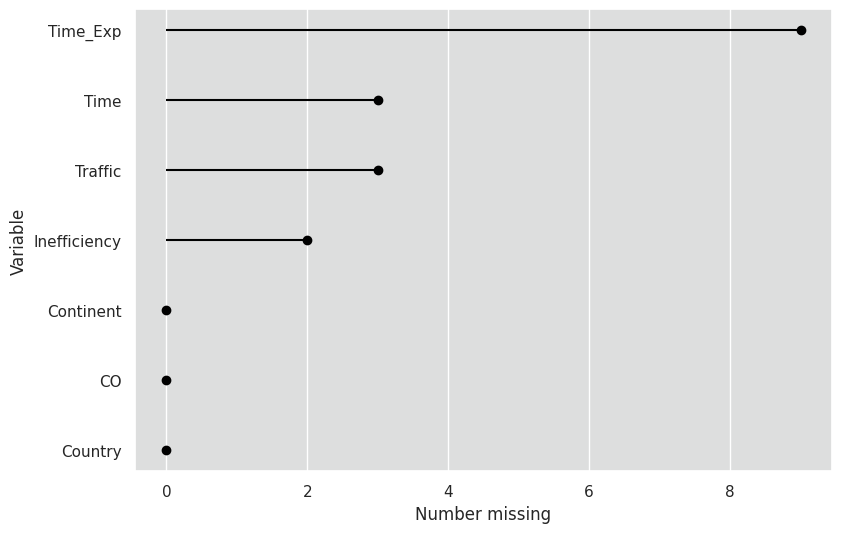

In [23]:
(
    traffic
    .missing
    .missing_variable_plot()
)

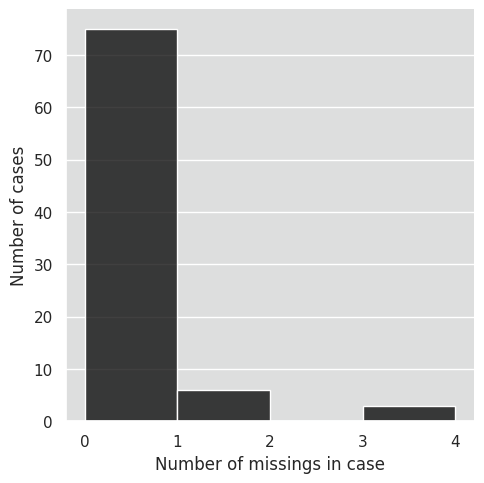

In [24]:
(
    traffic
    .missing
    .missing_case_plot()
)

<AxesSubplot: >

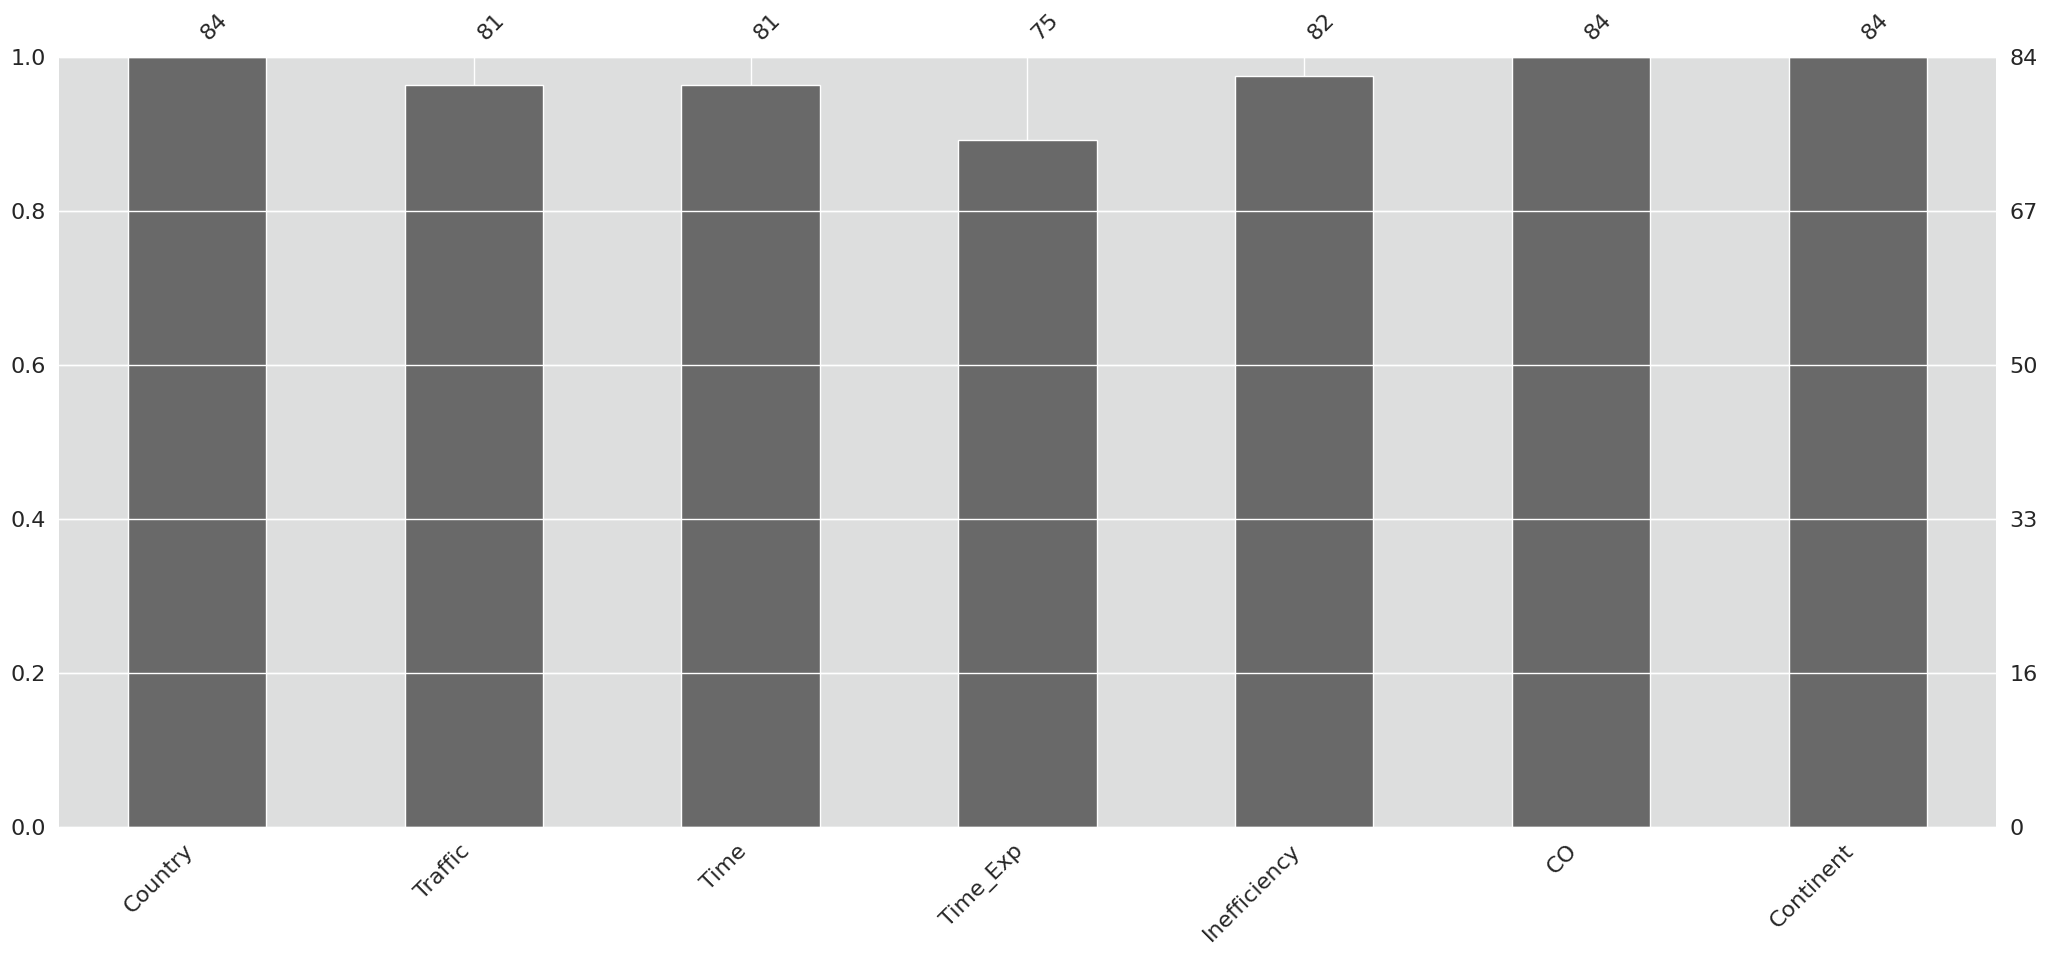

In [25]:
missingno.bar(df = traffic)

<AxesSubplot: >

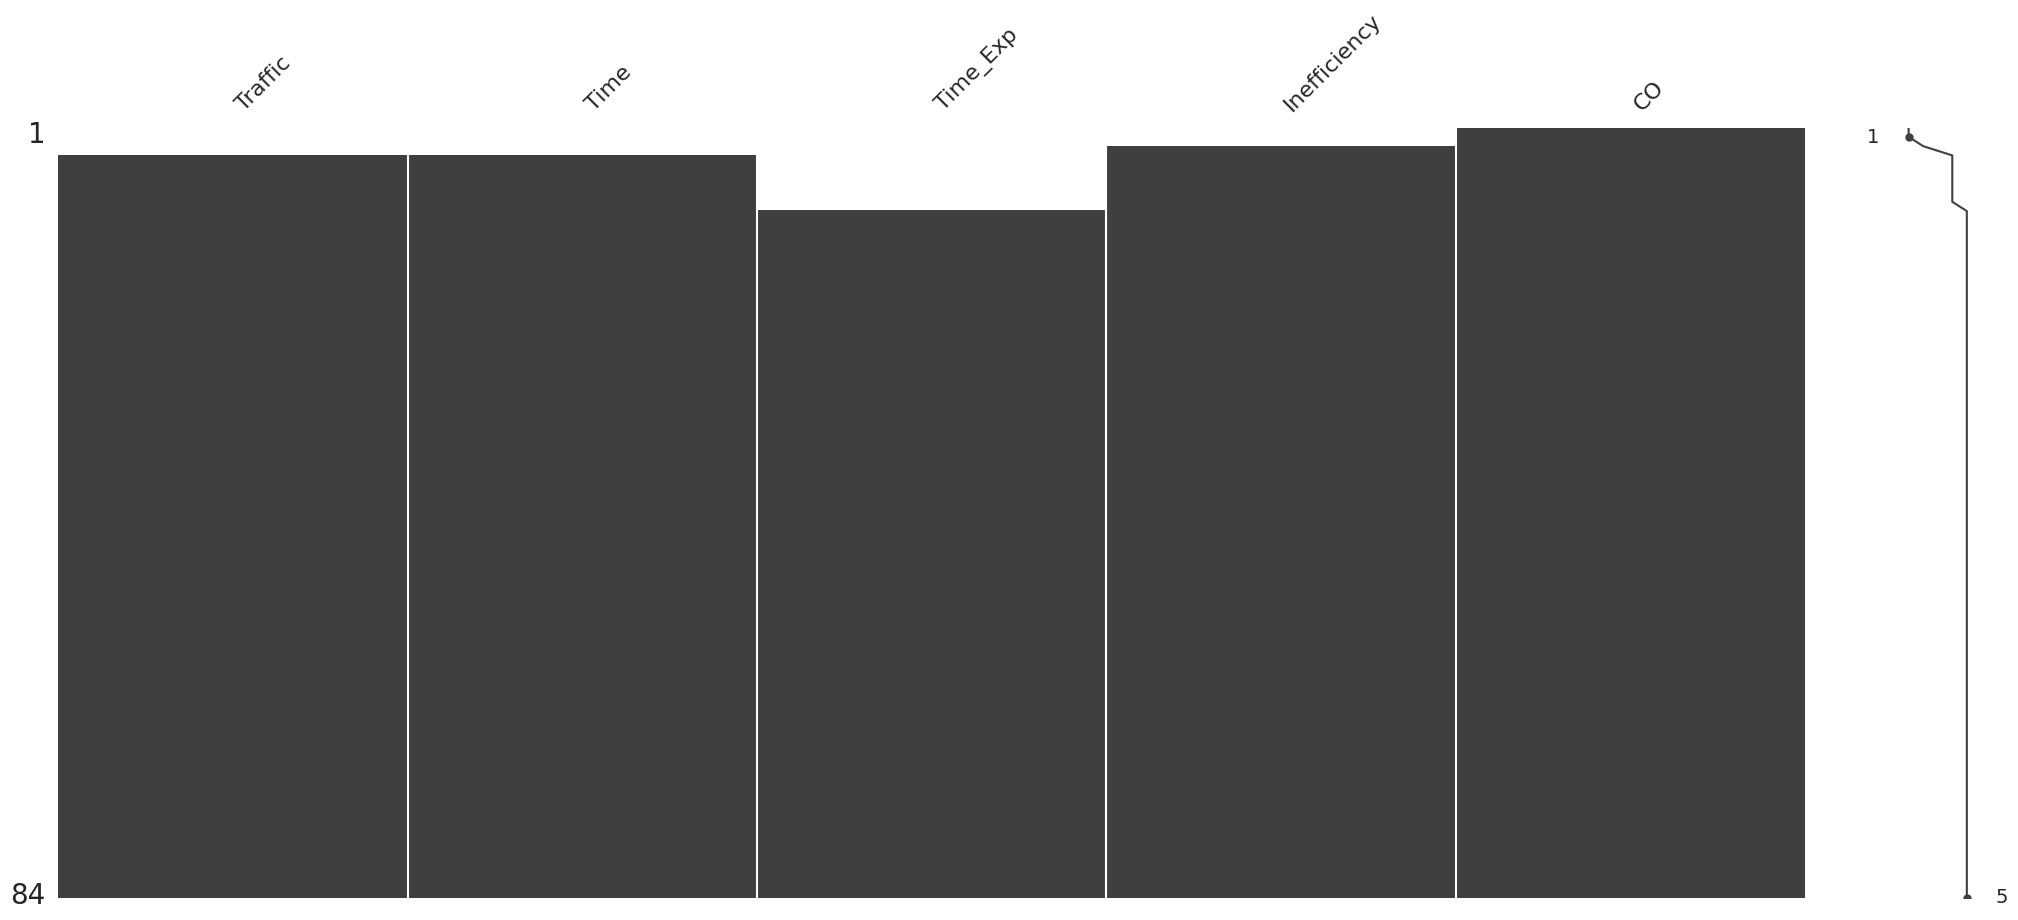

In [26]:
missingno.matrix(df = traffic.select_dtypes(np.number))

{'matrix': <AxesSubplot: >,
 'shading': <AxesSubplot: >,
 'totals': <AxesSubplot: >,
 'intersections': <AxesSubplot: ylabel='Intersection size'>}

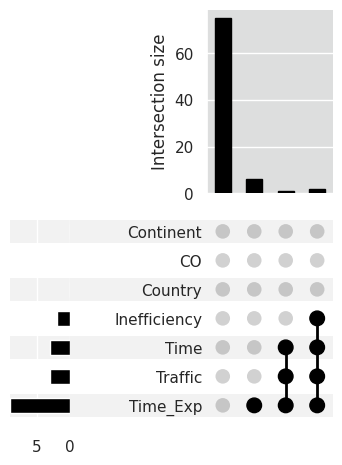

In [27]:
(
    traffic
    .missing
    .missing_upsetplot(
        variables=None,
        element_size = 30
    )
)

# Distribution Visualization

## Boxplot witout Outliers

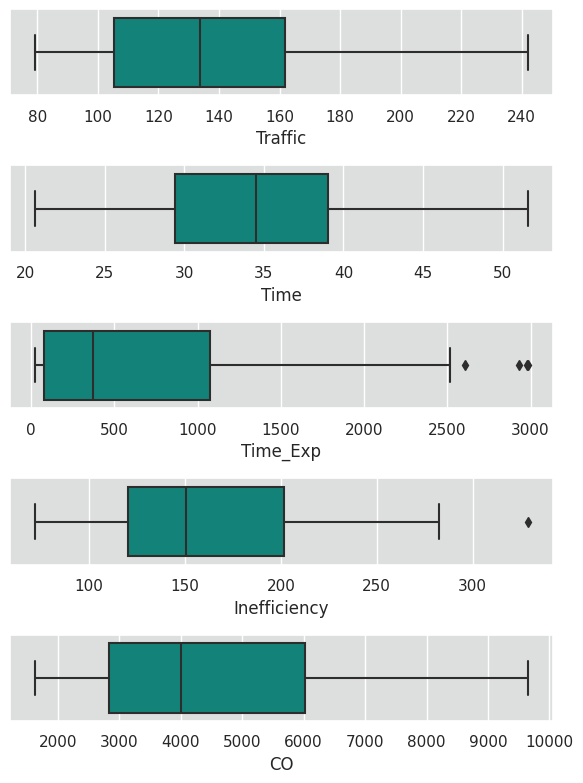

In [28]:
cols = traffic.select_dtypes(np.number).columns

fig, ax = plt.subplots( 5, figsize = (6,8))

for i, i_col in enumerate(cols):
    sns.boxplot(
        ax = ax[i],
        data = traffic,
        x = i_col,
        color = "#009688"
    )    

plt.tight_layout()

## Histplot

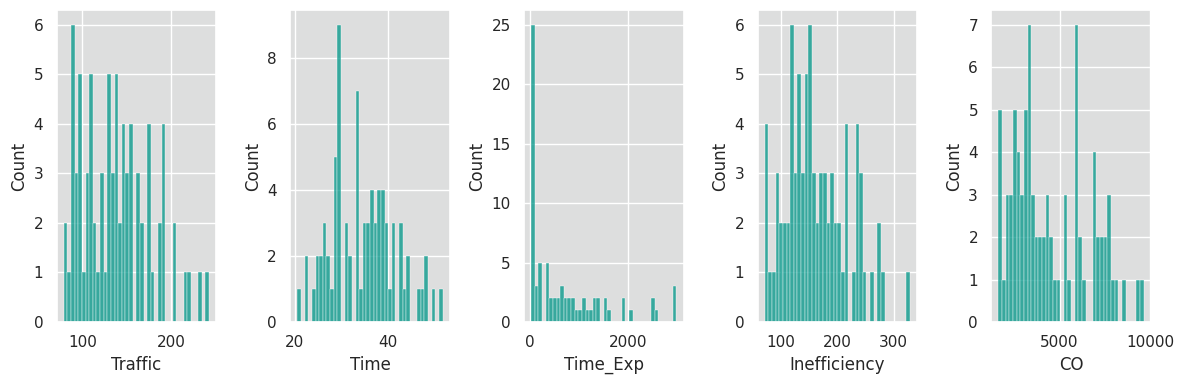

In [29]:
fig, ax = plt.subplots(1, 5, figsize = (12,4))

for i, i_col in enumerate(cols):
    sns.histplot(
        ax = ax[i],
        data = traffic,
        x = i_col,
        bins = 40,
        color = "#009688"
    )
plt.tight_layout()

# Heatmap

<AxesSubplot: >

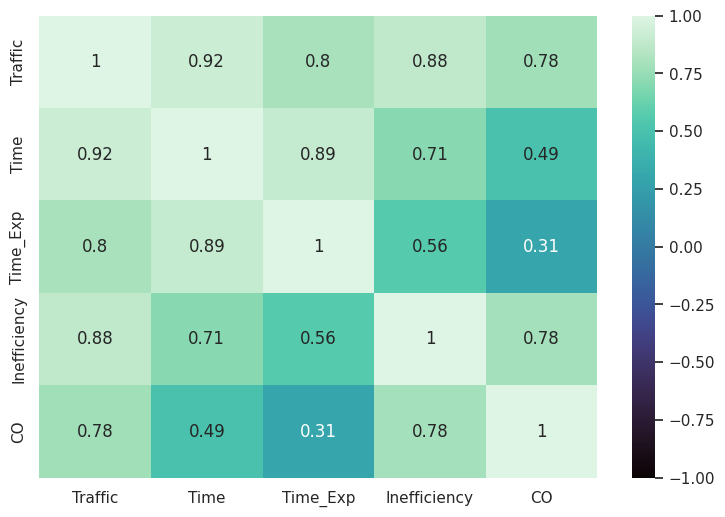

In [30]:
sns.heatmap(
    data= traffic.corr(),
    cmap = 'mako',
    center = 0,
    vmin= -1,
    vmax= 1,
    annot= True
)

## Question about correlation

- [x] ¿Cuál es el impacto del índice de ineficiencia en el índice principal de tráfico? ¿Hay alguna relación entre los niveles de ineficiencia y la satisfacción del tiempo de transporte de los usuarios?

<AxesSubplot: xlabel='Inefficiency', ylabel='Time_Exp'>

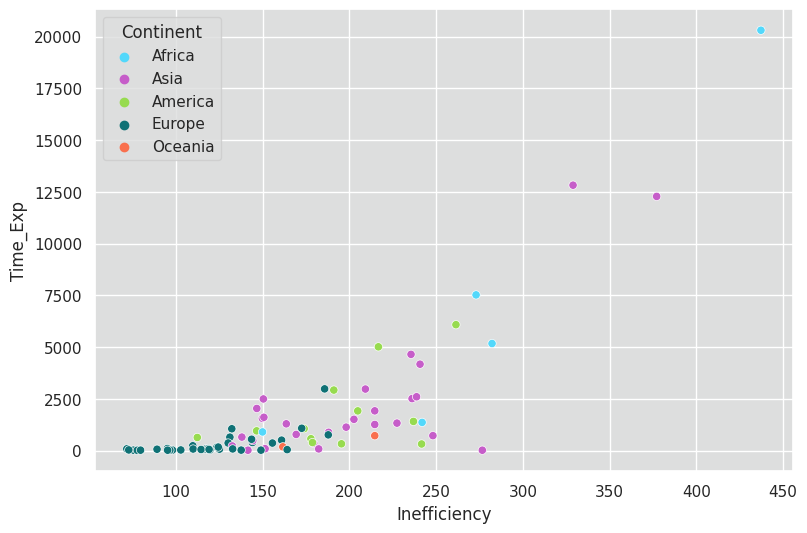

In [31]:
sns.scatterplot(
    data = df_traffic,
    x = 'Inefficiency',
    y = 'Time_Exp',
    hue = 'Continent',
    palette= continent_color
)

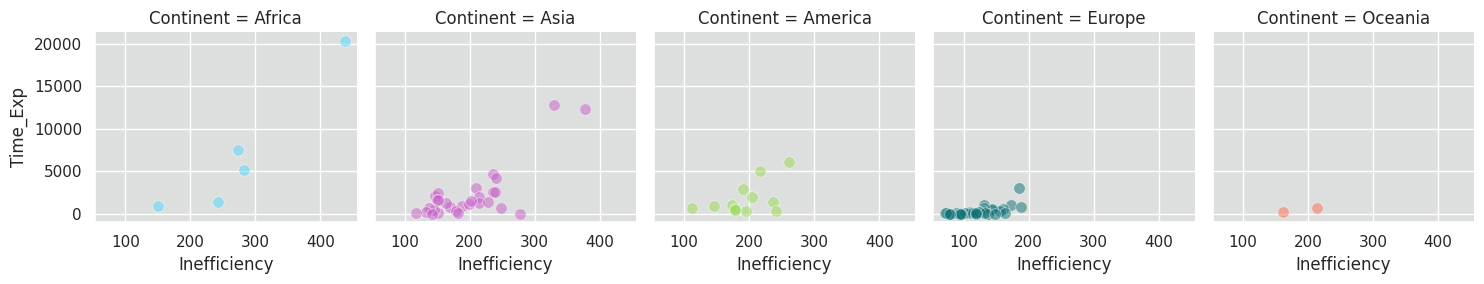

In [32]:
sns.FacetGrid(
    df_traffic,
    col="Continent",
    hue="Continent",
    palette=continent_color
).map(
    sns.scatterplot, 
    "Inefficiency", 
    "Time_Exp", 
    alpha=1/2, 
    s=70)

- [ ] ¿Existe una correlación entre el índice de tiempo y el índice de emisiones de CO₂?

<AxesSubplot: xlabel='Time_Exp', ylabel='CO'>

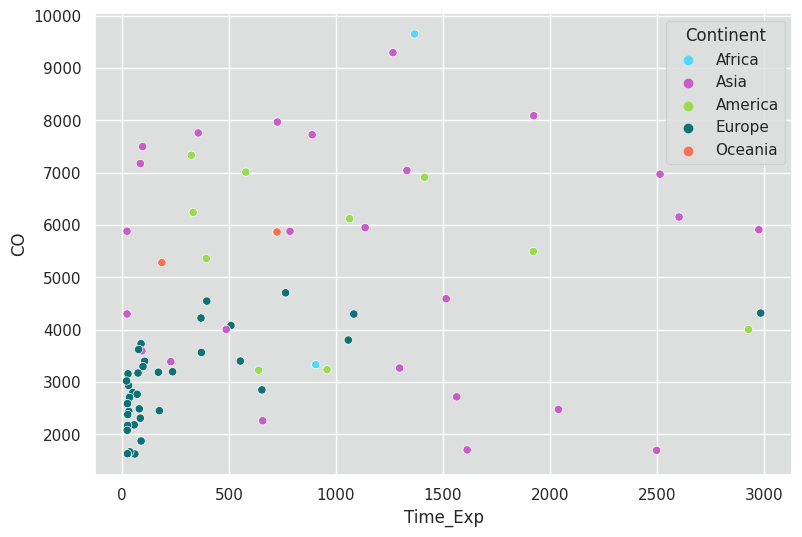

In [33]:
sns.scatterplot(
    data = traffic,
    x= 'Time_Exp',
    y = 'CO',
    hue = 'Continent',
    palette= continent_color
)

- [ ] ¿Cómo se correlacionan los índices de tráfico y los índices de emisiones de CO₂ en los distintos países?

<AxesSubplot: xlabel='Traffic', ylabel='CO'>

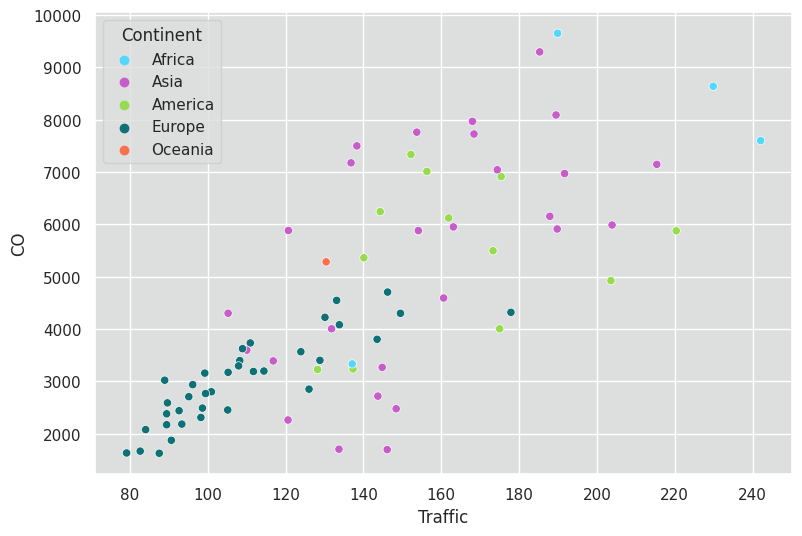

In [34]:
sns.scatterplot(
    data= traffic,
    x = 'Traffic',
    y = 'CO',
    hue = 'Continent',
    palette= continent_color
)

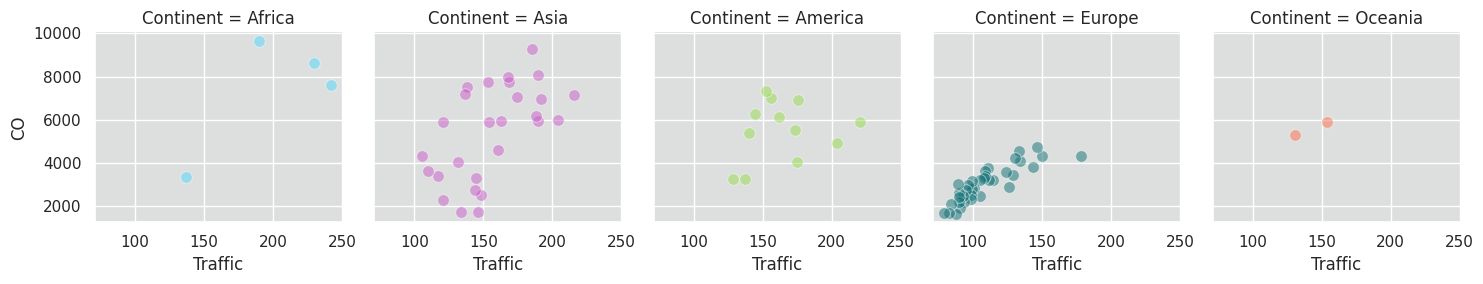

In [35]:
sns.FacetGrid(
    traffic,
    col="Continent",
    hue="Continent",
    palette=continent_color
).map(
    sns.scatterplot,
    "Traffic",
    "CO",
    alpha=1/2,
    s=70)


# Question About Variable

## Per continent

In [36]:
df_america = df_traffic[df_traffic['Continent'] == 'America']
df_europe = df_traffic[df_traffic['Continent'] == 'Europe']
df_asia = df_traffic[df_traffic['Continent'] == 'Asia']
df_oceania = df_traffic[df_traffic['Continent'] == 'Oceania']
df_africa = df_traffic[df_traffic['Continent'] == 'Africa']

- [ ] Tráfico peor 

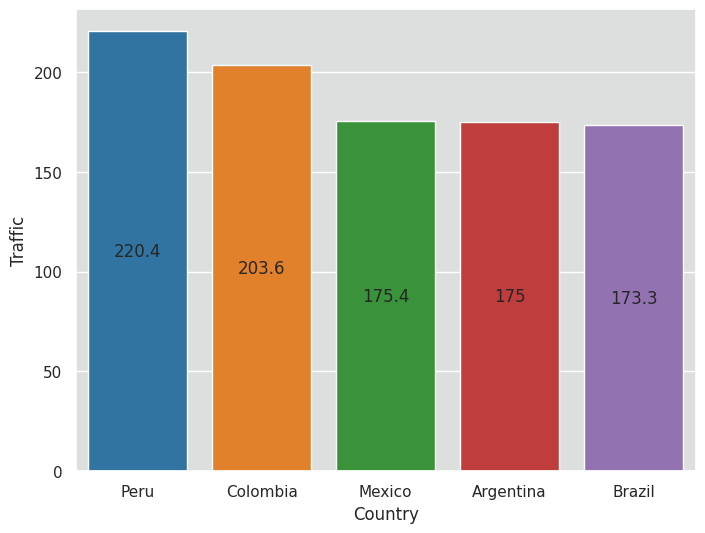

In [37]:
less_traffic_america = df_america.sort_values(by = 'Traffic', ascending= False).head()


fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(
    less_traffic_america,
    x = 'Country',
    y = 'Traffic', 
    ax = ax
)

ax.bar_label(ax.containers[-1], label_type='center');

Mejor

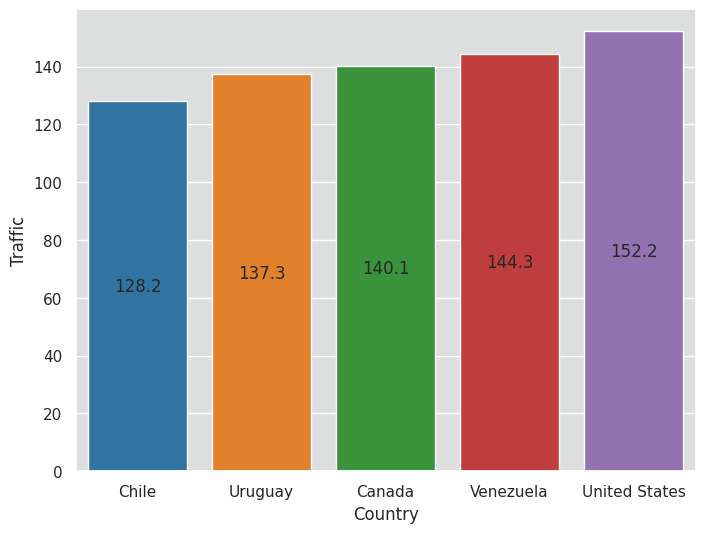

In [38]:
best_traffic_america =df_america.sort_values('Traffic', ascending= True).head()

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(
    best_traffic_america,
    x = 'Country',
    y = 'Traffic', 
    ax = ax
)

ax.bar_label(ax.containers[-1], label_type='center');

- [ ] ¿Cuáles son los 10 países con el mayor índice de tráfico?


In [39]:
df_tra = df_traffic[df_traffic['Continent'] != 'Africa']
top_traffic = df_tra.sort_values('Traffic', ascending= False).head(10)
top_traffic[['Country','Traffic', 'Continent']]

,Country,Traffic,Continent
1,Sri Lanka,272.5,Asia
2,Bangladesh,262.3,Asia
5,Peru,220.4,America
6,Iran,215.4,Asia
7,India,203.9,Asia
8,Colombia,203.6,America
9,Indonesia,191.7,Asia
11,Turkey,189.8,Asia
12,Jordan,189.5,Asia
13,Philippines,187.9,Asia


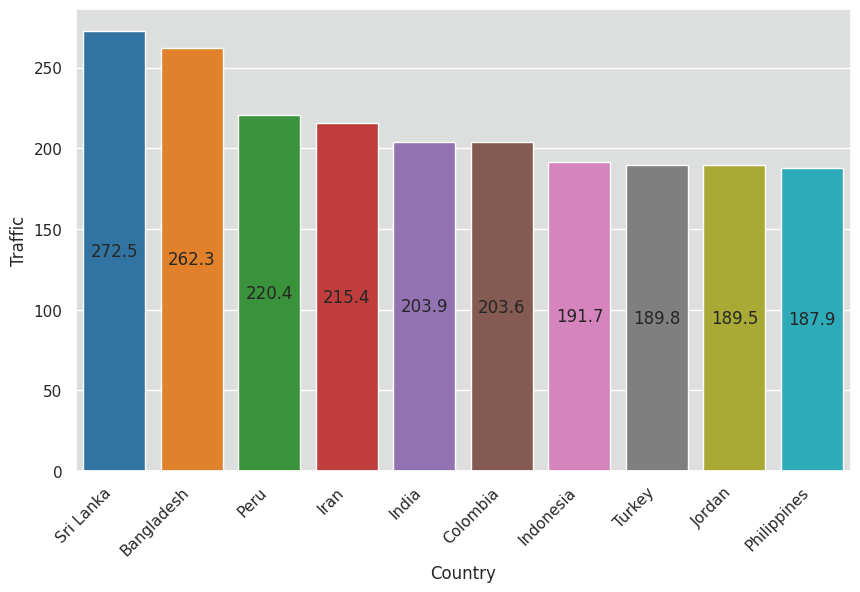

In [40]:


fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    top_traffic,
    x = 'Country',
    y = 'Traffic', 
    order = top_traffic.sort_values('Traffic', ascending=False).Country,
    ax = ax
)

ax.bar_label(ax.containers[-1], label_type='center')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()





- [ ] ¿Cuál es el continente con el índice de tráfico más alto?

In [41]:
tra = df_traffic.sort_values('Traffic', ascending= False).groupby('Continent').sum()

tra['Continent'] = tra.index

tra.sort_values('Traffic', ascending=False).Traffic

Continent
Asia       4737.5
Europe     3919.6
America    1968.0
Africa     1114.2
Oceania     284.6
Name: Traffic, dtype: float64

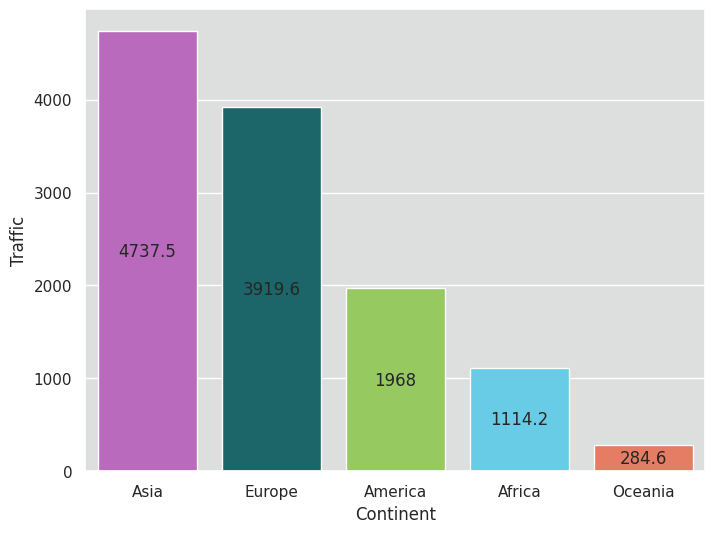

In [42]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    tra,
    x = 'Continent',
    y = 'Traffic',
    palette=continent_color,
    order= tra.sort_values('Traffic', ascending=False).Continent
)

ax.bar_label(ax.containers[-1], label_type='center');

- [ ] ¿Cuál es el país con el mayor índice de emisiones de CO₂ relacionadas con el tráfico?

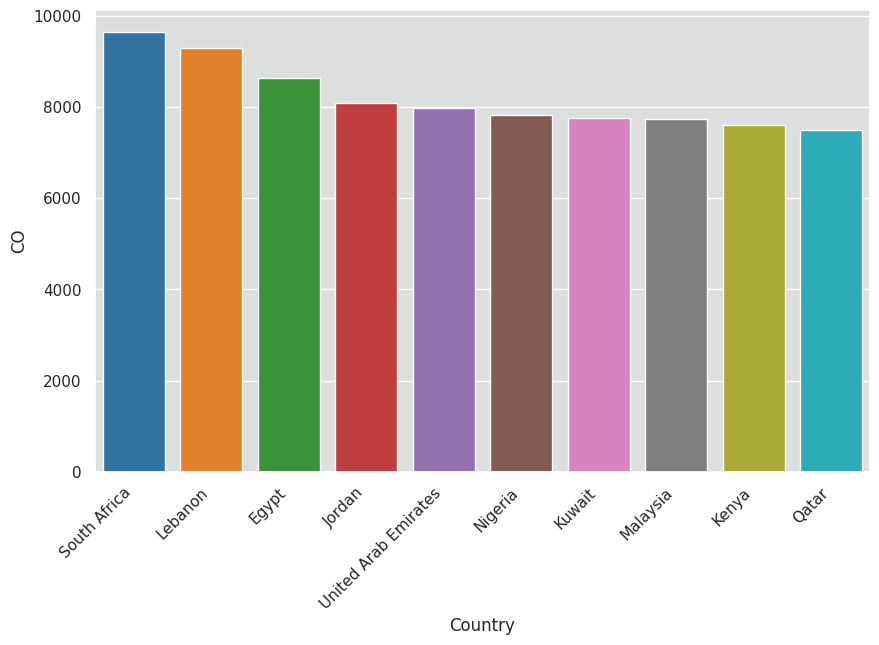

In [43]:
top_CO_world = df_traffic.sort_values('CO', ascending= False).head(10)

fig ,ax = plt.subplots(figsize = (10,6))

sns.barplot(
    top_CO_world,
    x = 'Country',
    y = 'CO',
    order = top_CO_world.sort_values('CO', ascending=False).Country,
    ax = ax
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

- [ ] ¿Cómo se distribuye la contaminación con respecto a los continentes?

In [44]:
co = df_traffic.sort_values('CO', ascending=False).groupby('Continent').sum()

co['Continent'] = co.index

co.sort_values('CO', ascending=False).CO

Continent
Asia       159141.7
Europe     108664.4
America     65751.0
Africa      37045.4
Oceania     11151.7
Name: CO, dtype: float64

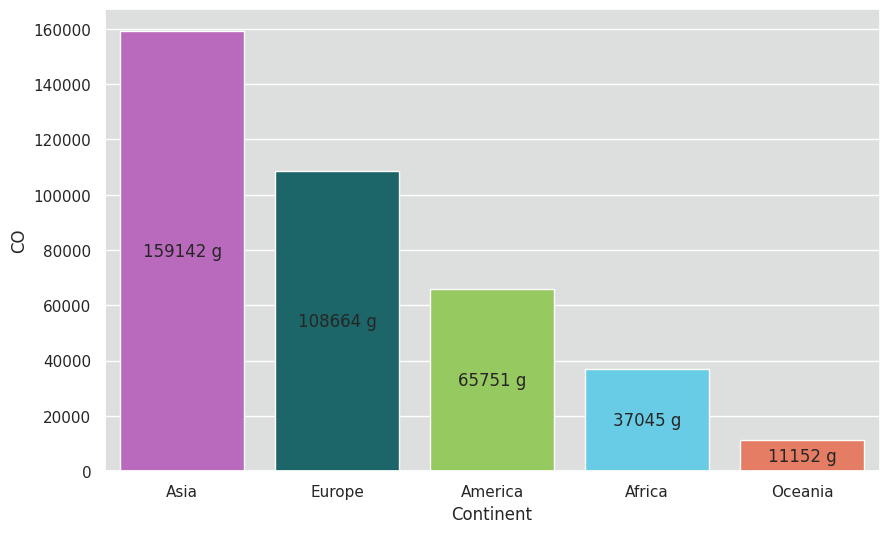

In [45]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    data=co,
    y = 'CO',
    x = 'Continent',
    palette=continent_color,
    order=co.sort_values('CO',ascending = False).Continent,
    ax = ax
)

ax.bar_label(ax.containers[-1],fmt='%.0f g' , label_type='center');

- [ ] ¿Cuál es el índice de emisión de CO2 promedio para un viaje de ida y vuelta al trabajo en esta ciudad?

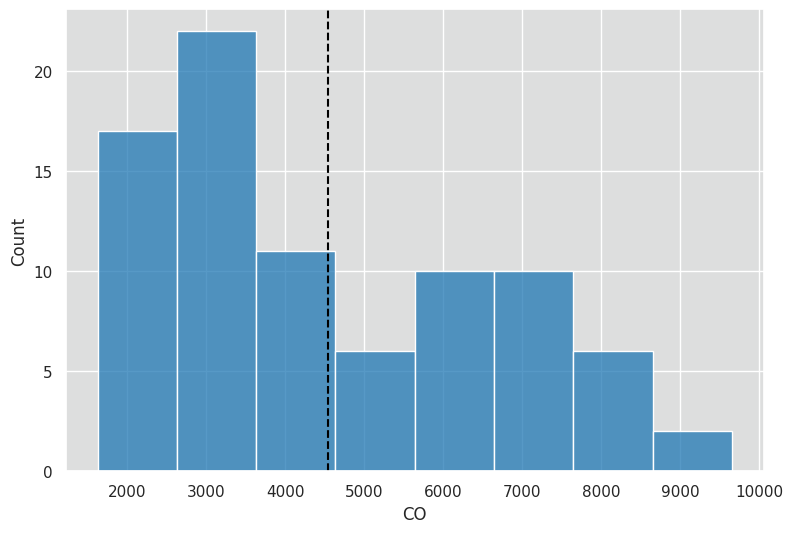

In [46]:
sns.histplot(
    df_traffic,
    x = 'CO'
)
mean = df_traffic['CO'].mean()
plt.axvline(mean, linestyle = '--', color = 'black')

- [ ] ¿Cuántos árboles serían necesarios para absorber la emisión de CO₂ durante el año?

In [47]:
consumption_Yearly = 240 * df_traffic.CO
df_traffic['trees_Needed'] = round((consumption_Yearly / 1000) / 21.77, 2)
trees = df_traffic.sort_values('trees_Needed', ascending = False).head(10)

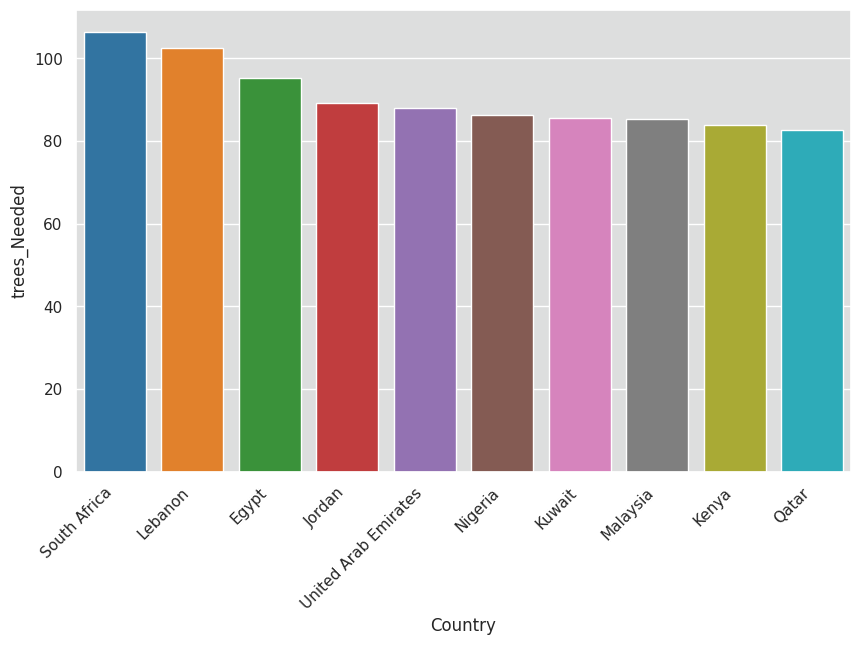

In [48]:
fig, ax = plt.subplots(figsize = (10,6))

sns.barplot(
    trees,
    x = 'Country',
    y = 'trees_Needed',
    order = trees.sort_values('trees_Needed', ascending=False).Country,
    ax = ax
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

- [ ] Mejores tiempos (más bajos) time / time_Exp

<AxesSubplot: xlabel='Time_Exp', ylabel='Country'>

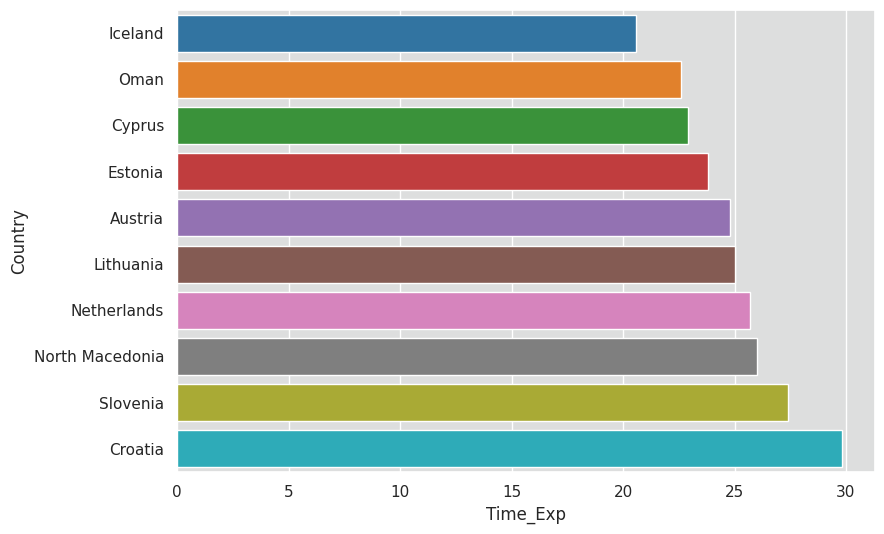

In [49]:
time_exp_top = df_traffic.sort_values('Time_Exp', ascending= True).head(10)

sns.barplot(
    time_exp_top,
    x = 'Time_Exp',
    y = 'Country'
)

- [ ] ¿Qué países tienen el peor y mejor índice de ineficiencia en el tráfico?

In [50]:
df_traffic.sort_values('Inefficiency', ascending = True)

,Country,Traffic,Time,Time_Exp,Inefficiency,CO,Continent,trees_Needed
75,Czech Republic,90.6,29.5,88.5,71.7,1872.7,Europe,20.65
82,Finland,82.6,27.2,36.0,72.8,1665.6,Europe,18.36
76,Lithuania,89.6,25.0,25.0,75.5,2587.8,Europe,28.53
79,Iceland,88.9,20.6,20.6,77.7,3020.9,Europe,33.30
83,Austria,79.1,24.8,24.8,79.6,1630.6,Europe,17.98
...,...,...,...,...,...,...,...,...
53,Oman,120.7,22.6,22.6,276.6,5883.0,Asia,64.86
4,Egypt,229.9,48.2,5176.6,282.2,8638.8,Africa,95.24
2,Bangladesh,262.3,57.4,12825.9,328.9,5406.3,Asia,59.60
1,Sri Lanka,272.5,56.9,12283.8,377.1,7286.9,Asia,80.33


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3aa0e2c3-1d5b-4b17-bb31-7a3c04c89158' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>